Yhdistelmätekniikat
===
# Tehtävä 1 - Luokittelu
Hannu Karstu - TTV19SAI

## Tehtävänanto
Tutustu koodiin: https://github.com/csc-training/intro-to-ml/blob/master/Extra-03.ipynb
Tee luokittelua MNIST-datasetille niin, että käytät siinä eri yhdistelmätekniikoita (Voting, Stacking, Bagging ja Boosting). Minkälaisella kokoonpanolla saadaan paras tulos?
Refaktoroi koodia niin, että teet yleiskäyttöisen luokan luokittelu ongelmien ratkaisemiseen, joka käyttää yhdistelmätekniikoita luokittelun toteuttamisessa.


## 1. Ladataan data

In [1]:
%matplotlib inline

from pml_utils import get_mnist, show_failures

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import __version__


from distutils.version import LooseVersion as LV
assert(LV(__version__) >= LV("0.20")), "Version >= 0.20 of sklearn is required."

In [2]:
X_train, y_train, X_test, y_test = get_mnist('MNIST')

print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)
print("")

Not downloading, file already exists: MNIST/train-images-idx3-ubyte
Not downloading, file already exists: MNIST/train-labels-idx1-ubyte
Not downloading, file already exists: MNIST/t10k-images-idx3-ubyte
Not downloading, file already exists: MNIST/t10k-labels-idx1-ubyte
MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 784)
y_train: (60000,)
X_test (10000, 784)
y_test (10000,)



The training data (`X_train`) is a matrix of size (60000, 784), i.e. it consists of 60000 digits expressed as 784 sized vectors (28x28 images flattened to 1D). `y_train` is a 60000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training digit.

### Pienennetään datasetit, jotta ohjelma toimisi nopeammin. Kommentoi pois jos haluat ajaa kokonaisella datalla.

In [3]:
# Pienennetään datasetit.
X_train = X_train[:6000,:]
y_train = y_train[:6000]
X_test = X_test[:1000,:]
y_test = y_test[:1000]

print("SMALLER DATASETS")
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

SMALLER DATASETS
X_train: (6000, 784)
y_train: (6000,)
X_test (1000, 784)
y_test (1000,)


## 2. Tehdään yleiskäyttöinen luokka
Tee luokittelua MNIST-datasetille niin, että käytät siinä eri yhdistelmätekniikoita (Voting, Stacking, Bagging ja Boosting). Minkälaisella kokoonpanolla saadaan paras tulos?
Refaktoroi koodia niin, että teet yleiskäyttöisen luokan luokittelu ongelmien ratkaisemiseen, joka käyttää yhdistelmätekniikoita luokittelun toteuttamisessa.

In [4]:
# Kaiken maailman importit
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier  
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Luokittelijoiden määrittelyt
clf_sgd = SGDClassifier()
clf_dt = DecisionTreeClassifier()
clf_bnb = BernoulliNB(binarize=128.)


# Luokittelijaluokka
class ultimateClf: 
    # Init
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.pred_vote = None
        self.pred_stacking = None
        
    # VOTING CLASSIFIER
    def votingClf(self):           
        # Nimi
        name = "votingClf"
        
        # Ajastin päälle
        start = timer()
        
        # Parametrit
        estimators = [('sgd',clf_sgd),('dt', clf_dt),('bnb', clf_bnb)]
        voting = "hard"       
        
        # Äänestyslajittelijan määrittely
        clf_vote = VotingClassifier(estimators=estimators,
                            voting=voting)
        
        # Mallin sovitus
        clf_vote.fit(self.X_train, self.y_train)
        
        # Ennuste
        self.pred_vote = clf_vote.predict(self.X_test)
        
        # Ajastin kiinni
        end = timer()
                
            
        # Palautetaan luokittelijan nimi, ennuste ja kulunut aika
        return name, self.pred_vote, round(end-start, 2)
 

    # STACKING CLASSIFIER
    def stackingClf(self):
        # Nimi
        name = "stackingClf"
               
        # Ajastin päälle
        start = timer()
        
        # Parametrit
        estimators = [('sgd',clf_sgd),('dt', clf_dt),('bnb', clf_bnb)]
        
        # Stacking-lajittelijan määrittely
        clf_stacking = StackingClassifier(
            estimators=estimators, final_estimator=LogisticRegression())
        
        # Mallin sovitus
        clf_stacking.fit(self.X_train,self.y_train)
        
        # Ennuste
        pred_stacking = clf_stacking.predict(self.X_test)
                       
        # Ajastin kiinni
        end = timer()
        
        # Palautetaan luokittelijan nimi, ennuste ja kulunut aika
        return name, pred_stacking, round(end-start, 2)
    
    
    # BAGGING CLASSIFIER
    def baggingClf(self):
        # Nimi
        name = "baggingClf"
               
        # Ajastin päälle
        start = timer()
        
        # Bagging-lajittelijan määrittely
        clf_bagging = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=10, random_state=0)
        
        # Mallin sovitus
        clf_bagging.fit(self.X_train,self.y_train)
        
        # Ennuste
        pred_bagging = clf_bagging.predict(self.X_test)
                       
        # Ajastin kiinni
        end = timer()
        
        # Palautetaan luokittelijan nimi, ennuste ja kulunut aika
        return name, pred_bagging, round(end-start, 2)
    
    
    # ADABOOST CLASSIFIER
    def adaboostClf(self):
        # Nimi
        name = "adaboostClf"
               
        # Ajastin päälle
        start = timer()
        
                
        # Adaboost-lajittelijan määrittely
        clf_adaboost = AdaBoostClassifier(n_estimators=100, random_state=0)
        
        # Mallin sovitus
        clf_adaboost.fit(self.X_train,self.y_train)
        
        # Ennuste
        pred_adaboost = clf_adaboost.predict(self.X_test)
                       
        # Ajastin kiinni
        end = timer()
        
        # Palautetaan luokittelijan nimi, ennuste ja kulunut aika
        return name, pred_adaboost, round(end-start, 2)
    
    

    
        
        
    

## 3. Luokittelut

In [5]:
# Annetaan ultimateClassifierille datat
ucf = ultimateClf(X_train, y_train, X_test, y_test)

### Luodaan lista johon kerätään:
 - luokittelijan nimi
 - tarkkuus eli accuracy score
 - mallin sovitukseen ja ennustukseen kulunut aika

In [6]:
lista = []

### VotingClassifier

In [7]:
name, pred, time = ucf.votingClf()

malli = [name,accuracy_score(ucf.y_test, pred),time]

lista.append(malli)

### StackingClassifier

In [8]:
name, pred, time = ucf.stackingClf()

malli = [name,accuracy_score(ucf.y_test, pred),time]

lista.append(malli)

### BaggingClassifier

In [9]:
name, pred, time = ucf.baggingClf()

malli = [name,accuracy_score(ucf.y_test, pred),time]

lista.append(malli)

### AdaBoostClassifier

In [10]:
name, pred, time = ucf.adaboostClf()

malli = [name,accuracy_score(ucf.y_test, pred),time]

lista.append(malli)

## 4. Laitetaan saadut arvot Pandasin dataframeen

In [11]:
import pandas as pd

df = pd.DataFrame(data=lista)
df = df.rename(columns={0: 'luokittelija', 1: 'tarkkuus', 2: 'aika (s)'})

### Järjestettynä tarkkuuden mukaan
Tarkin ennuste ylimpänä

In [12]:
df = df.sort_values(by=['tarkkuus'], ascending=False)
df

,luokittelija,tarkkuus,aika (s)
2,baggingClf,0.936,89.69
0,votingClf,0.862,7.57
1,stackingClf,0.845,32.95
3,adaboostClf,0.472,23.02


### Järjestettynä kuluneen ajan mukaan
Pienin aika ylimpänä

In [13]:
df = df.sort_values(by=['aika (s)'])
df

,luokittelija,tarkkuus,aika (s)
0,votingClf,0.862,7.57
3,adaboostClf,0.472,23.02
1,stackingClf,0.845,32.95
2,baggingClf,0.936,89.69


## 5. Plotataan luokittelijat

Text(0, 0.5, 'aika (s)')

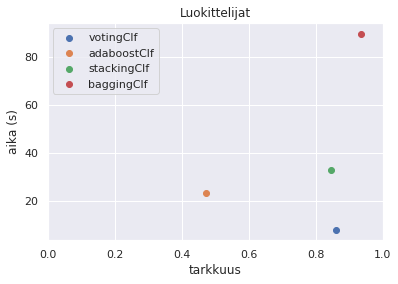

In [14]:
for i in range (0, len(df)):
    plt.scatter(df['tarkkuus'].iloc[i],df['aika (s)'].iloc[i], label=df['luokittelija'].iloc[i])
    
plt.title('Luokittelijat')
plt.legend()
plt.xlim(0, 1);
plt.xlabel('tarkkuus')
plt.ylabel('aika (s)')